# West Nile Virus Prediction - Kaggle Challenge

### Background

West Nile virus is most commonly spread to humans through infected mosquitos. Around 20% of people who become infected with the virus develop symptoms ranging from a persistent fever, to serious neurological illnesses that can result in death.

In 2002, the first human cases of West Nile virus were reported in Chicago.

### Problem Statement

To predict when and where different species of mosquitos will test positive for West Nile virus using a strong classifier model using weather, location, and spraying data to help the City of Chicago and CPHD more efficiently and effectively allocate resources towards preventing transmission. 

In [1]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from xgboost.sklearn import XGBClassifier

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, accuracy_score

plt.style.use('fivethirtyeight')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline
sns.set_style('darkgrid')

/Users/akhilajoseph/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# loading data from all .csv files provided
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')
spray = pd.read_csv('../data/spray.csv')
weather = pd.read_csv('../data/weather.csv')

In [3]:
# examining train df - all dtypes except for date seems to be right and no missing values found
train.info()
train.Species.value_counts()
train.Trap.value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Date                    10506 non-null  object 
 1   Address                 10506 non-null  object 
 2   Species                 10506 non-null  object 
 3   Block                   10506 non-null  int64  
 4   Street                  10506 non-null  object 
 5   Trap                    10506 non-null  object 
 6   AddressNumberAndStreet  10506 non-null  object 
 7   Latitude                10506 non-null  float64
 8   Longitude               10506 non-null  float64
 9   AddressAccuracy         10506 non-null  int64  
 10  NumMosquitos            10506 non-null  int64  
 11  WnvPresent              10506 non-null  int64  
dtypes: float64(2), int64(4), object(6)
memory usage: 985.1+ KB


T900     750
T115     542
T138     314
T002     185
T135     183
        ... 
T238       7
T076       5
T094B      5
T237       3
T040       2
Name: Trap, Length: 136, dtype: int64

### Data Cleaning

**1. Observations in training dataset and how to deal with them**

    1) Date field is recorded as object datatype and needs to be converted to Datetime
    2) Address, Street, Block, AddressNumberandStreet and AddressAccuracy columns 
    are redundant with Latitiude and Longitude info. These will be removed. 
    3) 7 types of species are observed and recorded as categorical variables. These are to 
    be convered to dummies.
    4) Rows in train df can be grouped by Latitude, Longitude, Date, Species and WnvPresent and summed up by number of mosquitoes.

In [4]:
# Address, Street, Block, AddressNumberandStreet and AddressAccuracy columns are redundant with Latitiude and Longitude info.
train = train[['Trap','Latitude','Longitude','Date','Species','NumMosquitos','WnvPresent']].groupby(['Trap','Latitude',
                           'Longitude','Date','Species','WnvPresent']).agg({'NumMosquitos':np.sum}).reset_index()

# convert date column to proper datatye
train.Date = pd.to_datetime(train.Date)

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8610 entries, 0 to 8609
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Trap          8610 non-null   object        
 1   Latitude      8610 non-null   float64       
 2   Longitude     8610 non-null   float64       
 3   Date          8610 non-null   datetime64[ns]
 4   Species       8610 non-null   object        
 5   WnvPresent    8610 non-null   int64         
 6   NumMosquitos  8610 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(2), object(2)
memory usage: 471.0+ KB


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116293 entries, 0 to 116292
Data columns (total 11 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Id                      116293 non-null  int64  
 1   Date                    116293 non-null  object 
 2   Address                 116293 non-null  object 
 3   Species                 116293 non-null  object 
 4   Block                   116293 non-null  int64  
 5   Street                  116293 non-null  object 
 6   Trap                    116293 non-null  object 
 7   AddressNumberAndStreet  116293 non-null  object 
 8   Latitude                116293 non-null  float64
 9   Longitude               116293 non-null  float64
 10  AddressAccuracy         116293 non-null  int64  
dtypes: float64(2), int64(3), object(6)
memory usage: 9.8+ MB


**2. Observations in test dataset and perform the same cleaning performed on training set**

    1) Date field is recorded as object datatype and needs to be converted to Datetime
    2) Address, Street, Block, AddressNumberandStreet and AddressAccuracy columns 
    are redundant with Latitiude and Longitude info. These should be removed. 
    3) 7 types of species are observed and recorded as categorical variables. These are to be convered to dummies.
    4) NumMosquitos feature is missing in testing set and thus removing from training set. 

In [7]:
# dropping column that is not available in test data
train.drop('NumMosquitos', axis = 1, inplace = True)

# since train df was grouped by some of NumMosquitos feature, let's proceed to drop duplicates created due to this. 
train.drop_duplicates(inplace = True)

# cleaning test df
# dropping redundant columns
test = test[['Trap','Latitude','Longitude','Date','Species']]
# test.drop_duplicates(inplace = True)

# datatype of date column
test.Date = pd.to_datetime(test.Date)

In [8]:
#  check to see if test and train are identical
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116293 entries, 0 to 116292
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   Trap       116293 non-null  object        
 1   Latitude   116293 non-null  float64       
 2   Longitude  116293 non-null  float64       
 3   Date       116293 non-null  datetime64[ns]
 4   Species    116293 non-null  object        
dtypes: datetime64[ns](1), float64(2), object(2)
memory usage: 4.4+ MB


**3. Observations from spray dataset and corrections performed**

    1) Date field is recorded as object datatype and needs to be converted to Datetime
    2) Time column has null values, but since time is not a significant column leaving it 
    as it is. 
    3) Drop rows with duplicate info.

In [9]:
# examining spray df - missing values found in time column, date column conversion
spray.info()
spray.Date = pd.to_datetime(spray.Date)
spray.drop_duplicates(inplace = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14835 entries, 0 to 14834
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       14835 non-null  object 
 1   Time       14251 non-null  object 
 2   Latitude   14835 non-null  float64
 3   Longitude  14835 non-null  float64
dtypes: float64(2), object(2)
memory usage: 463.7+ KB


In [10]:
spray.shape

(14294, 4)

**4. Observations from weather dataset and corrections performed**

    1) Date field is recorded as object datatype and needs to be converted to Datetime
    2) Checked for missing values with 'M in all non-numeric columns and identified 
    high occurence of missing values for station 2 - planned to stick with just 
    1 station: Station 1 for the quality of info available and dropped the Station column
    3) Dropped columns - 'Depth','SnowFall','Water1' due to high occurence of missing 
    values
    4) Imputed values for M and T before converting these columns into float datatype - WetBulb,PrecipTotal, StnPressure, SeaLevel
    5) Coverted these columns to int datatype based on the values in these columns - Heat, Cool, TAvg and Depart
    6) Converted column - CodeSum to 0 and 1 based on whitespace value

In [11]:
# no missing data. But there are columns where dtyes have to be corrected
weather.head()
# weather.shape

Station        Date  Tmax  Tmin Tavg Depart  DewPoint WetBulb Heat Cool  \
0        1  2007-05-01    83    50   67     14        51      56    0    2   
1        2  2007-05-01    84    52   68      M        51      57    0    3   
2        1  2007-05-02    59    42   51     -3        42      47   14    0   
3        2  2007-05-02    60    43   52      M        42      47   13    0   
4        1  2007-05-03    66    46   56      2        40      48    9    0   

   ... CodeSum Depth Water1 SnowFall PrecipTotal StnPressure SeaLevel  \
0  ...             0      M      0.0        0.00       29.10    29.82   
1  ...             M      M        M        0.00       29.18    29.82   
2  ...      BR     0      M      0.0        0.00       29.38    30.09   
3  ...   BR HZ     M      M        M        0.00       29.44    30.08   
4  ...             0      M      0.0        0.00       29.39    30.12   

  ResultSpeed ResultDir  AvgSpeed  
0         1.7        27       9.2  
1         2.7        25       9.6  
2        13.0         4      13.4  
3        13.3         2      13.4  
4        11.7         7      11.9  

[5 rows x 22 columns]

In [12]:
# converting data column to datetime object and checking all columns
weather.Date = pd.to_datetime(weather.Date)
weather.columns

Index(['Station', 'Date', 'Tmax', 'Tmin', 'Tavg', 'Depart', 'DewPoint',
       'WetBulb', 'Heat', 'Cool', 'Sunrise', 'Sunset', 'CodeSum', 'Depth',
       'Water1', 'SnowFall', 'PrecipTotal', 'StnPressure', 'SeaLevel',
       'ResultSpeed', 'ResultDir', 'AvgSpeed'],
      dtype='object')

In [13]:
# identifying non-numeric columns to check for missing values
check_missing_values = weather.select_dtypes(include='object').columns
check_missing_values

Index(['Tavg', 'Depart', 'WetBulb', 'Heat', 'Cool', 'Sunrise', 'Sunset',
       'CodeSum', 'Depth', 'Water1', 'SnowFall', 'PrecipTotal', 'StnPressure',
       'SeaLevel', 'AvgSpeed'],
      dtype='object')

In [14]:
# checking for non-numeric columns with missing values by Station
for col in weather[check_missing_values]:
    station_1 = len(weather[(weather[col].str.contains('M'))| (weather[col].str.contains('-')) & (weather.Station==1)])
    print (col + ' has ' + str(station_1) + ' missing values at station 1')
    station_2 = len(weather[(weather[col].str.contains('M')) | (weather[col].str.contains('-')) & (weather.Station==2)])
    print (col + ' has ' + str(station_2) + ' missing values at station 2')
    print ('')

Tavg has 11 missing values at station 1
Tavg has 11 missing values at station 2

Depart has 2028 missing values at station 1
Depart has 1472 missing values at station 2

WetBulb has 4 missing values at station 1
WetBulb has 4 missing values at station 2

Heat has 11 missing values at station 1
Heat has 11 missing values at station 2

Cool has 11 missing values at station 1
Cool has 11 missing values at station 2

Sunrise has 0 missing values at station 1
Sunrise has 1472 missing values at station 2

Sunset has 0 missing values at station 1
Sunset has 1472 missing values at station 2

CodeSum has 3 missing values at station 1
CodeSum has 3 missing values at station 2

Depth has 1472 missing values at station 1
Depth has 1472 missing values at station 2

Water1 has 2944 missing values at station 1
Water1 has 2944 missing values at station 2

SnowFall has 1472 missing values at station 1
SnowFall has 1472 missing values at station 2

PrecipTotal has 2 missing values at station 1
PrecipTot

In [15]:
# dropping station 2 as it has high number of missing values and station clumn
weather = weather[weather.Station==1].drop('Station', axis = 1)

In [16]:
# drop the following columns that high occurence of missing values - Depth, SnowFall, Water1
weather.drop(['Depth','SnowFall','Water1'], axis = 1, inplace = True)

In [17]:
# cleanup columns to convert relevant ones to float datatype
check_dtypes = weather.select_dtypes(include='object').columns
check_dtypes

# checking for non-numeric columns with M or T values
for col in weather[check_dtypes]:
    checks_M = len(weather[(weather[col].str.contains('M'))])  # WetBulb, CodeSum, StnPressure, SeaLevel
    checks_T = len(weather[(weather[col].str.contains('T'))])  # CodeSum, PrecipTotal
    print (col + ' has ' + str(checks_M) + ' M values and '+ str(checks_T) + ' T values.')

Tavg has 0 M values and 0 T values.
Depart has 0 M values and 0 T values.
WetBulb has 3 M values and 0 T values.
Heat has 0 M values and 0 T values.
Cool has 0 M values and 0 T values.
Sunrise has 0 M values and 0 T values.
Sunset has 0 M values and 0 T values.
CodeSum has 3 M values and 174 T values.
PrecipTotal has 0 M values and 163 T values.
StnPressure has 2 M values and 0 T values.
SeaLevel has 5 M values and 0 T values.
AvgSpeed has 0 M values and 0 T values.


In [18]:
# function to impute values for T and M values and change dtype to float in weather df. 
def impute_col(column):
    weather[column] = weather[column].str.replace('T','0.0001')
    weather[column] = weather[column].str.replace('M','0.0')
    weather[column] = weather[column].astype(float)
    
# function to convert columns from object dtype to int
def covert_dtypetoint(column):
    weather[column] = weather[column].astype(int)

# calling above created function to impute values & change dtype for the following columns
impute_col('WetBulb')
impute_col('StnPressure')
impute_col('SeaLevel')
impute_col('PrecipTotal')
impute_col('AvgSpeed') 

# calling above created function change dtype to int
covert_dtypetoint('Heat')
covert_dtypetoint('Cool')
covert_dtypetoint('Tavg') 
covert_dtypetoint('Depart') 

# convert sunrise and sunset time to float
weather.Sunrise = weather.Sunrise.astype(float)
weather.Sunset = weather.Sunset.astype(float)

In [19]:
# updating codesum column with 1 if there is white space and 0 if otherwise and changing dtype to float
# If CodeSum contains letters, they signify some type of significant weather event. 
weather.CodeSum = weather.CodeSum.str.strip()
weather.CodeSum[weather.CodeSum.str.contains('^\w')] = '1'
weather.CodeSum[weather.CodeSum!='1'] = '0'
weather.CodeSum = weather.CodeSum.astype(float)

/Users/akhilajoseph/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/akhilajoseph/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [20]:
# check after cleaning df
weather.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1472 entries, 0 to 2942
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         1472 non-null   datetime64[ns]
 1   Tmax         1472 non-null   int64         
 2   Tmin         1472 non-null   int64         
 3   Tavg         1472 non-null   int64         
 4   Depart       1472 non-null   int64         
 5   DewPoint     1472 non-null   int64         
 6   WetBulb      1472 non-null   float64       
 7   Heat         1472 non-null   int64         
 8   Cool         1472 non-null   int64         
 9   Sunrise      1472 non-null   float64       
 10  Sunset       1472 non-null   float64       
 11  CodeSum      1472 non-null   float64       
 12  PrecipTotal  1472 non-null   float64       
 13  StnPressure  1472 non-null   float64       
 14  SeaLevel     1472 non-null   float64       
 15  ResultSpeed  1472 non-null   float64       
 16  Result

### EDA

#### Observations and Insights

1. Data availability:<br>
    a. Train data: 2007, 2009, 2011 and 2013<br>
    b. Test data: 2008, 2010, 2012 and 2014<br>
    c. Spray data: 2011 and 2013<br>
    d. Weather data: 2007 - 2014<br>
    
2. Significant increase in number of spray locations in 2013 vs. 2011
3. Looking at traps with WNV presence vs. sprays, clusters can be identified where sprayed. For some reason, central area did not have any spray locations
4. Out of total 7 species of mosquitoes only 3 species are seen to be carriers of WNV virus
5. 2009 and 2011 are the years where overall WNV count was lower. Need to dig deeper into the reason why. Probably weather conditions were not favorable for the mosquitoes in these years.
6. Only 8 out of 134 traps have > 10 WNV positive
7. After identifying top traps and trying to plot sprays over these traps explained the spraying locations much better. 

**Train data available for 2007, 2009, 2011 and 2013**

In [21]:
train.groupby(train.Date.dt.year).count()

Trap  Latitude  Longitude  Date  Species  WnvPresent
Date                                                      
2007  2837      2837       2837  2837     2837        2837
2009  1921      1921       1921  1921     1921        1921
2011  1794      1794       1794  1794     1794        1794
2013  2058      2058       2058  2058     2058        2058

**Test data available for 2008, 2010, 2012 and 2014**

In [22]:
test.groupby(test.Date.dt.year).count()

Trap  Latitude  Longitude   Date  Species
Date                                            
2008  30498     30498      30498  30498    30498
2010  36557     36557      36557  36557    36557
2012  27115     27115      27115  27115    27115
2014  22123     22123      22123  22123    22123

**Spray data available for 2011(very few data points) and 2013**

In [23]:
spray.groupby(spray.Date.dt.year).count()

Date   Time  Latitude  Longitude
Date                                   
2011   1668   1084      1668       1668
2013  12626  12626     12626      12626

**Weather data is available for all years from 2007 - 2014**

In [24]:
weather.groupby(weather.Date.dt.year).count()

Date  Tmax  Tmin  Tavg  Depart  DewPoint  WetBulb  Heat  Cool  Sunrise  \
Date                                                                           
2007   184   184   184   184     184       184      184   184   184      184   
2008   184   184   184   184     184       184      184   184   184      184   
2009   184   184   184   184     184       184      184   184   184      184   
2010   184   184   184   184     184       184      184   184   184      184   
2011   184   184   184   184     184       184      184   184   184      184   
2012   184   184   184   184     184       184      184   184   184      184   
2013   184   184   184   184     184       184      184   184   184      184   
2014   184   184   184   184     184       184      184   184   184      184   

      Sunset  CodeSum  PrecipTotal  StnPressure  SeaLevel  ResultSpeed  \
Date                                                                     
2007     184      184          184          184       184          184   
2008     184      184          184          184       184          184   
2009     184      184          184          184       184          184   
2010     184      184          184          184       184          184   
2011     184      184          184          184       184          184   
2012     184      184          184          184       184          184   
2013     184      184          184          184       184          184   
2014     184      184          184          184       184          184   

      ResultDir  AvgSpeed  
Date                       
2007        184       184  
2008        184       184  
2009        184       184  
2010        184       184  
2011        184       184  
2012        184       184  
2013        184       184  
2014        184       184

#### Examining the target variable

**Our train dataset is an unbalanced set with 95% of rows stating information with no virus present**

In [25]:
# examining our target variable
train.WnvPresent.value_counts()
train.WnvPresent.value_counts(normalize  = True)

0    0.946922
1    0.053078
Name: WnvPresent, dtype: float64

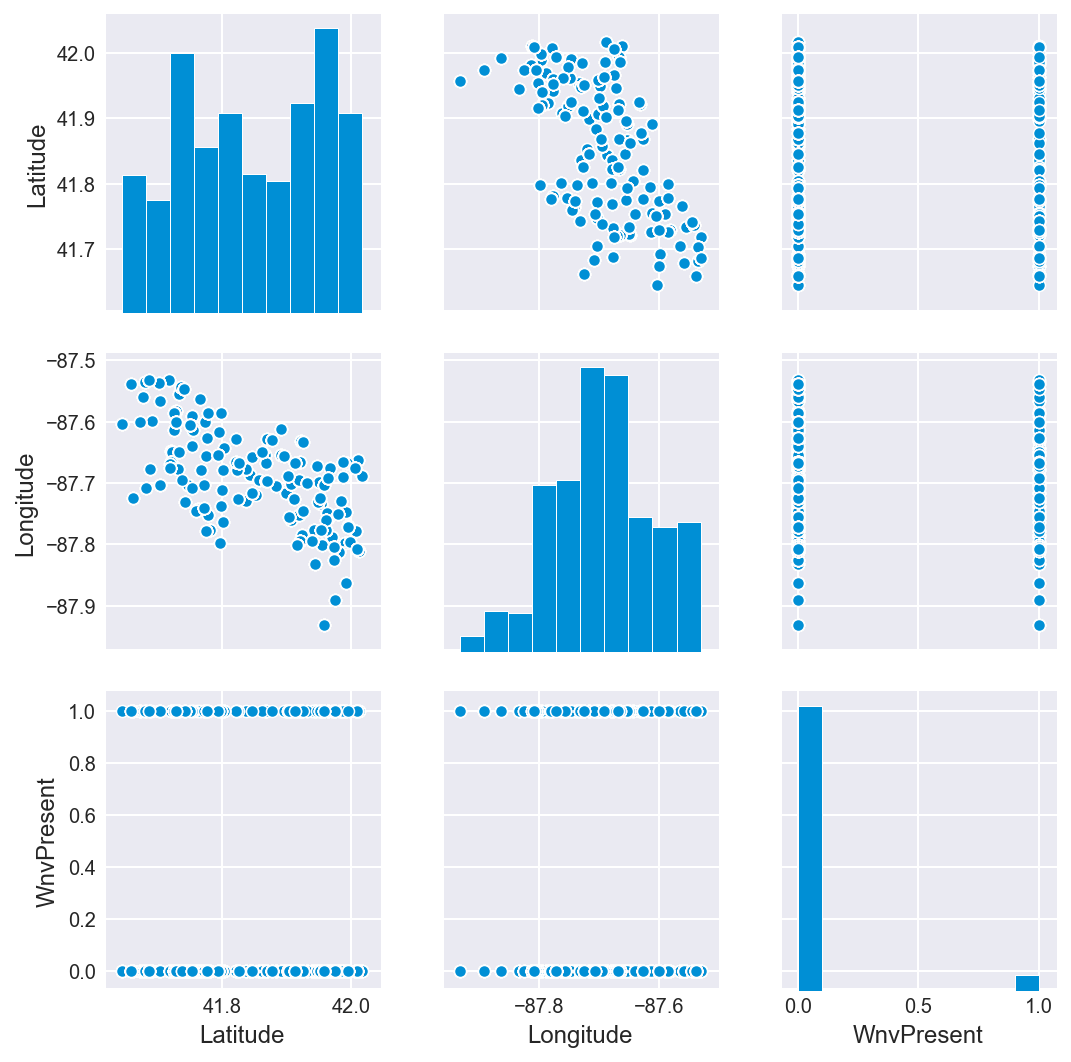

In [26]:
# pairplot to check numeric variables in train set
sns.pairplot(train, vars = ['Latitude','Longitude','WnvPresent']);

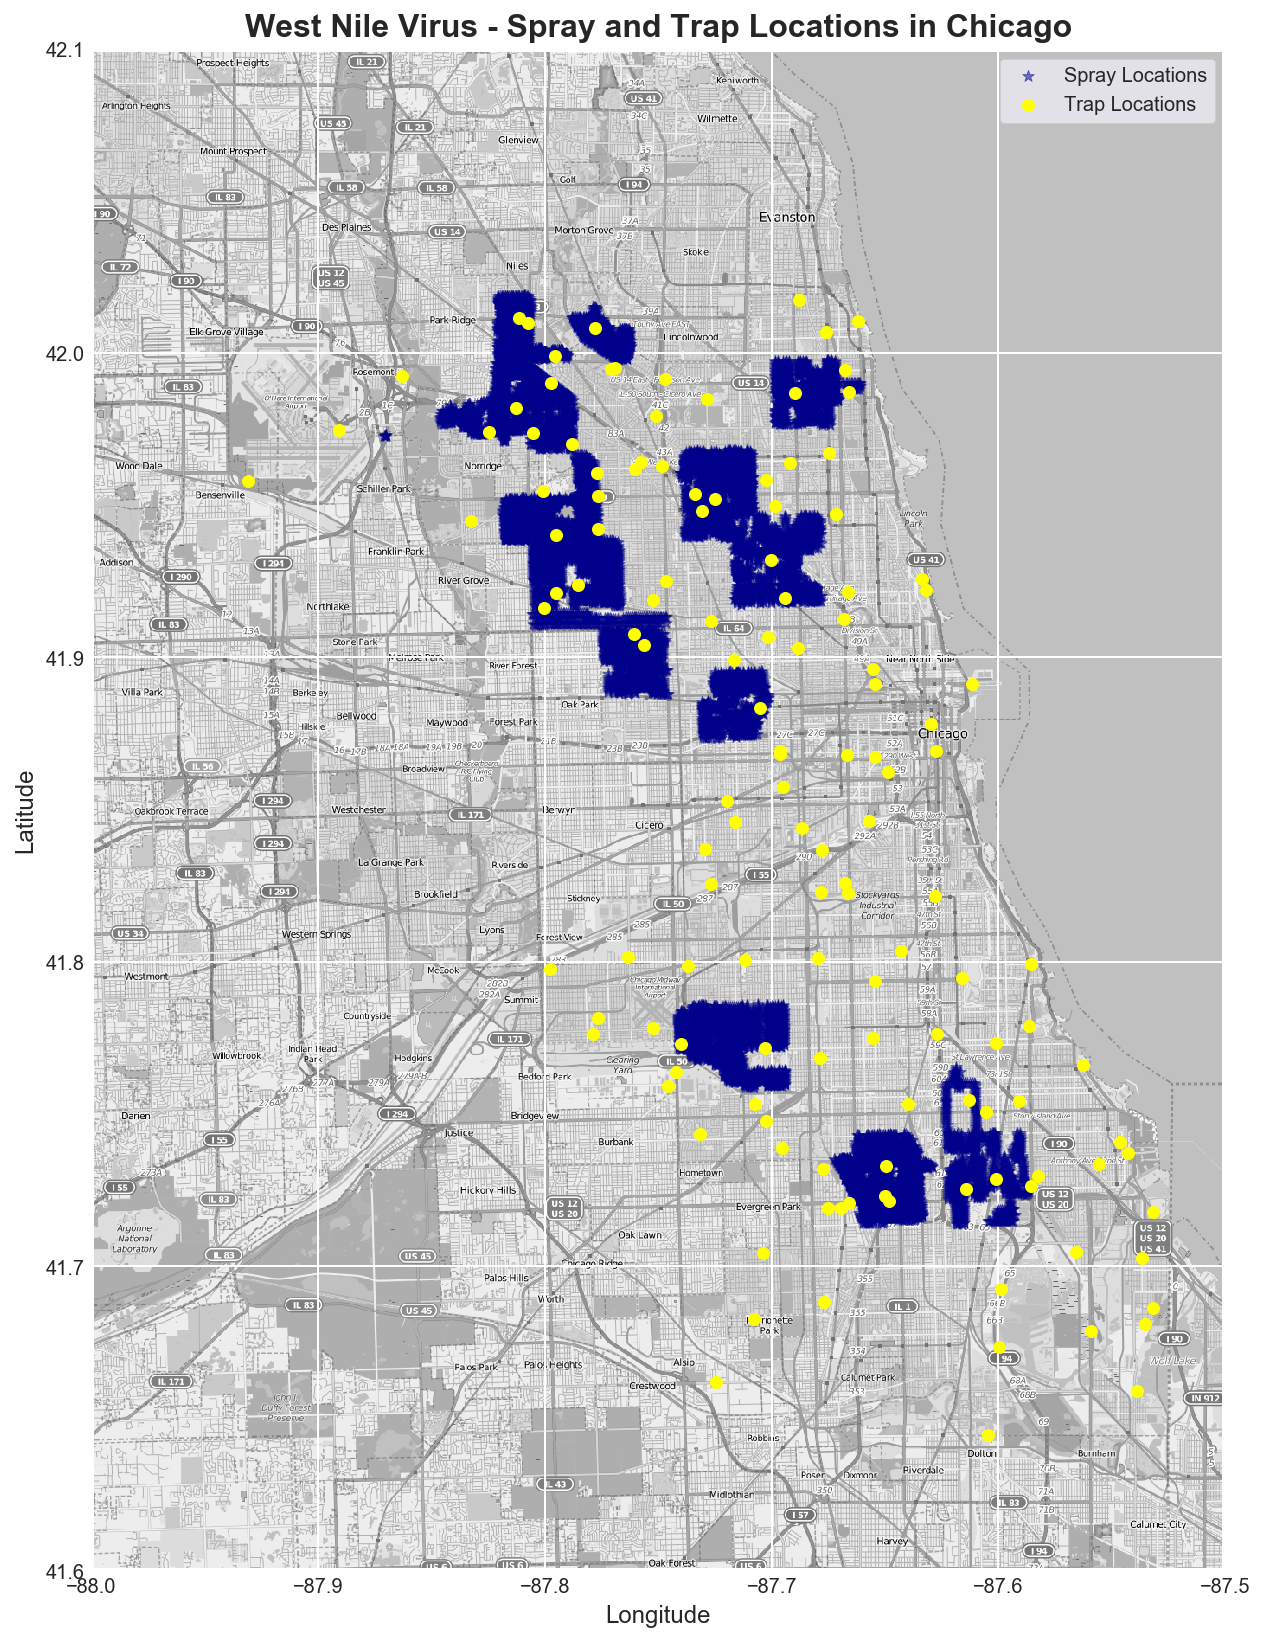

In [27]:
# plotting spray and trap locations
mapdata = np.loadtxt("../input/mapdata_copyright_openstreetmap_contributors.txt")

# plot map
aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-88, -87.5, 41.6, 42.1)

plt.figure(figsize=(10,14))
plt.imshow(mapdata, 
           cmap=plt.get_cmap('gray'), 
           extent=lon_lat_box, 
           aspect=aspect)

# spray locations
sprays = spray[['Longitude', 'Latitude']].drop_duplicates()
sprays = sprays[sprays['Latitude'] < 42.3]  # excluding outliers
plt.scatter(sprays['Longitude'], sprays['Latitude'], marker='*', color='darkblue',alpha=.5, label='Spray Locations');

# trap locations
traps = train[['Date', 'Trap','Longitude', 'Latitude', 'WnvPresent']]
locations = traps[['Longitude', 'Latitude']].drop_duplicates().values
plt.scatter(locations[:,0], locations[:,1], marker='o', label='Trap Locations', color = 'yellow');


plt.title('West Nile Virus - Spray and Trap Locations in Chicago', weight = 'bold', size = 16)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(frameon=1);

Trap locations are rather scattered when compared to spray locations.<br>
- Since spray location data is only available for 2 years - 2011 and 2013 and Trap locations are available for 4 years - 2007, 2009, 2011 and 2013.<br> 
- Tried to map 2011 and 2013 traps and spray locations to see if there are any linkages/ variations.<br>
- Also tried to filter traps with WNV presence and plot the spray info by year (shown in the below map view)

In [28]:
spray.Date.dt.year.value_counts().sort_values()

2011     1668
2013    12626
Name: Date, dtype: int64

In [29]:
train['year'] = train.Date.dt.year
test['year'] = test.Date.dt.year

In [30]:
train.groupby('Trap')['year'].value_counts()

Trap  year
T001  2007    14
T002  2007    45
      2009    38
      2013    37
      2011    30
              ..
T900  2009    60
      2013    57
T903  2011    44
      2009    40
      2013    17
Name: year, Length: 343, dtype: int64

In [31]:
# creating a df with rows WNV is present
df = train[train.WnvPresent == 1]
df.head()

Trap  Latitude  Longitude       Date                 Species  WnvPresent  \
36  T002  41.95469 -87.800991 2007-08-01  CULEX PIPIENS/RESTUANS           1   
42  T002  41.95469 -87.800991 2007-08-15  CULEX PIPIENS/RESTUANS           1   
45  T002  41.95469 -87.800991 2007-08-21  CULEX PIPIENS/RESTUANS           1   
48  T002  41.95469 -87.800991 2007-08-24  CULEX PIPIENS/RESTUANS           1   
49  T002  41.95469 -87.800991 2007-09-04           CULEX PIPIENS           1   

    year  
36  2007  
42  2007  
45  2007  
48  2007  
49  2007

/Users/akhilajoseph/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


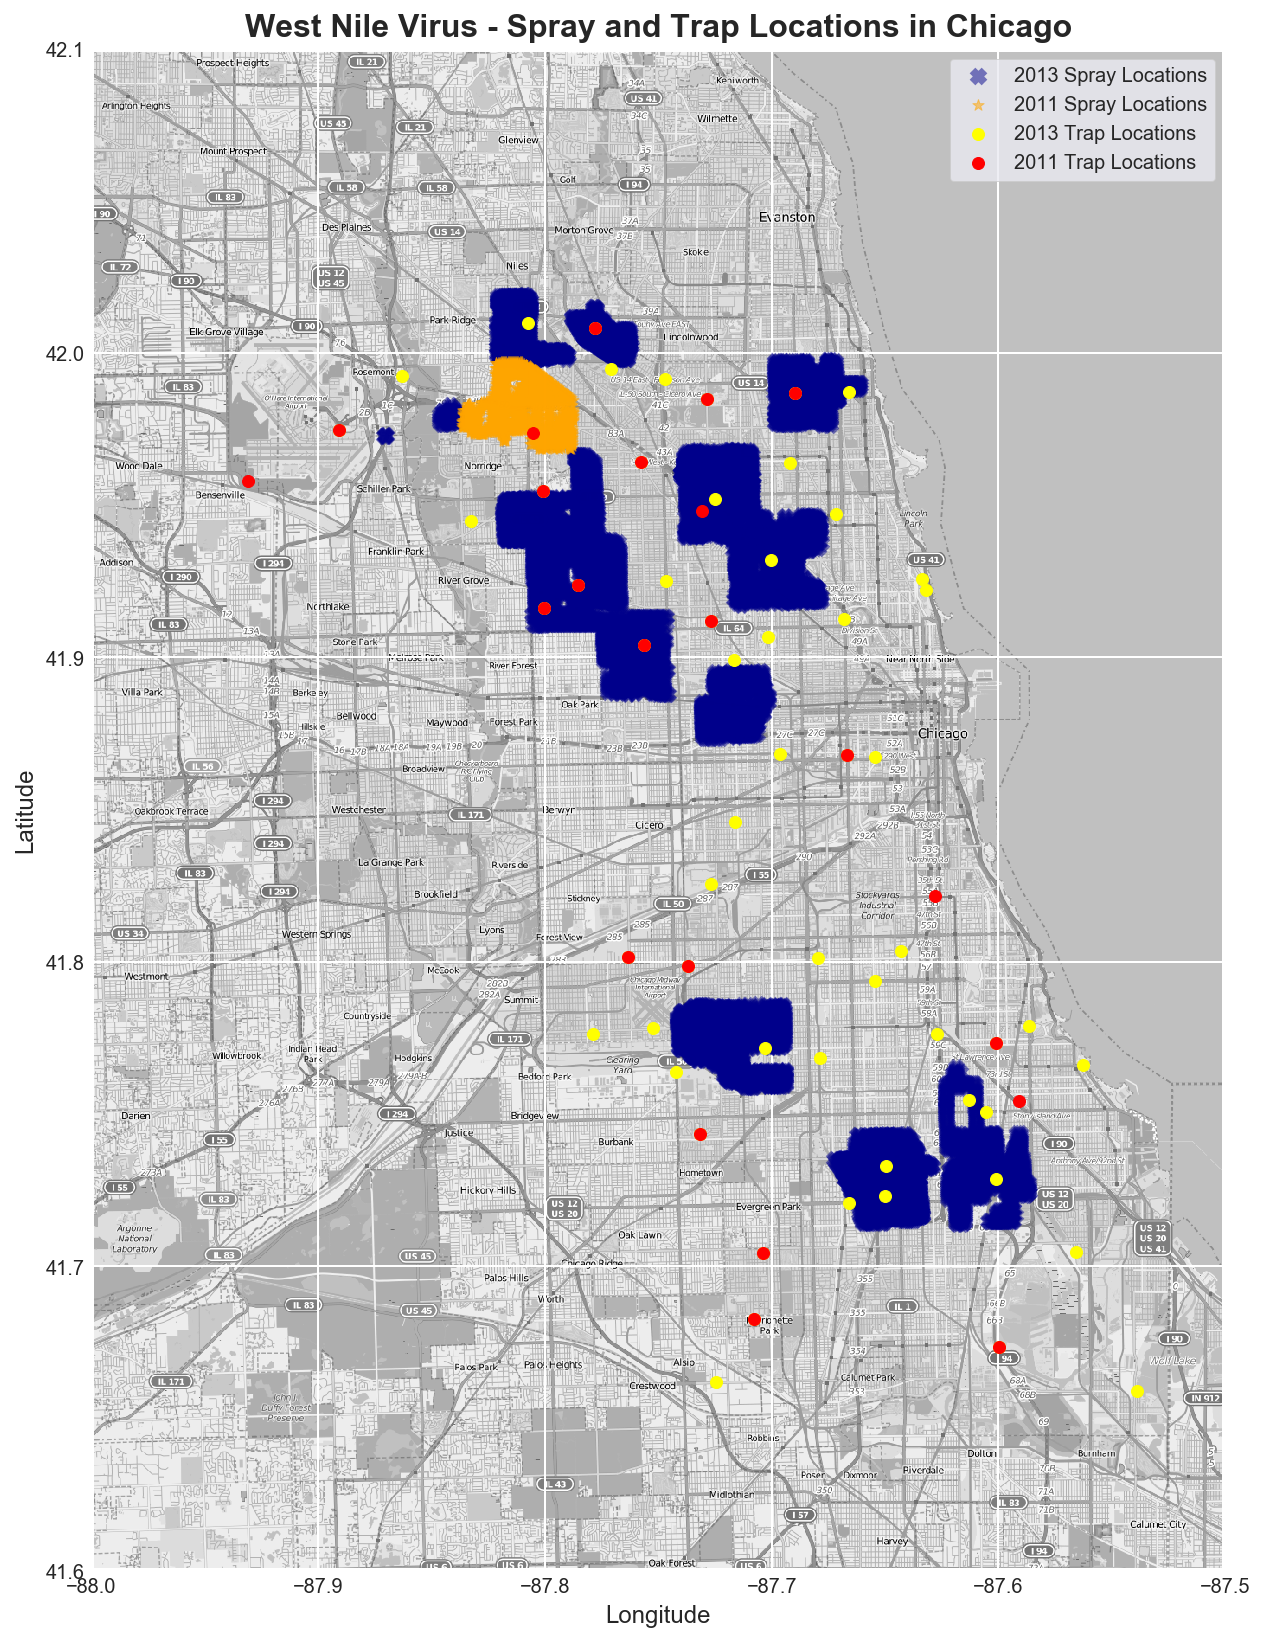

In [32]:
# plotting spray and trap locations by year
mapdata = np.loadtxt("../input/mapdata_copyright_openstreetmap_contributors.txt")

# plot map
aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-88, -87.5, 41.6, 42.1)

plt.figure(figsize=(10,14))
plt.imshow(mapdata, 
           cmap=plt.get_cmap('gray'), 
           extent=lon_lat_box, 
           aspect=aspect)

df.Date = pd.to_datetime(df.Date)

# spray locations
sprays_2013 = spray[spray.Date.dt.year == 2013][['Longitude', 'Latitude']].drop_duplicates()
sprays_2011 = spray[spray.Date.dt.year == 2011][['Longitude', 'Latitude']].drop_duplicates()
sprays_2013 = sprays_2013[sprays_2013['Latitude'] < 42.3]  # excluding outliers
sprays_2011 = sprays_2011[sprays_2011['Latitude'] < 42.3]  # excluding outliers
plt.scatter(sprays_2013['Longitude'], sprays_2013['Latitude'], marker='x', color='darkblue',alpha=.5, label='2013 Spray Locations');
plt.scatter(sprays_2011['Longitude'], sprays_2011['Latitude'], marker='*', color='orange',alpha=.5, label='2011 Spray Locations');

# trap locations
traps_2013 = df[df.Date.dt.year == 2013][['Trap','Longitude', 'Latitude', 'WnvPresent']]
traps_2011 = df[df.Date.dt.year == 2011][['Trap','Longitude', 'Latitude', 'WnvPresent']]
locations_13 = traps_2013[['Longitude', 'Latitude']].drop_duplicates().values
locations_11 = traps_2011[['Longitude', 'Latitude']].drop_duplicates().values
plt.scatter(locations_13[:,0], locations_13[:,1], marker='o', label='2013 Trap Locations', color = 'yellow');
plt.scatter(locations_11[:,0], locations_11[:,1], marker='o', label='2011 Trap Locations', color = 'red');

plt.title('West Nile Virus - Spray and Trap Locations in Chicago', weight = 'bold', size = 16)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(frameon=1);

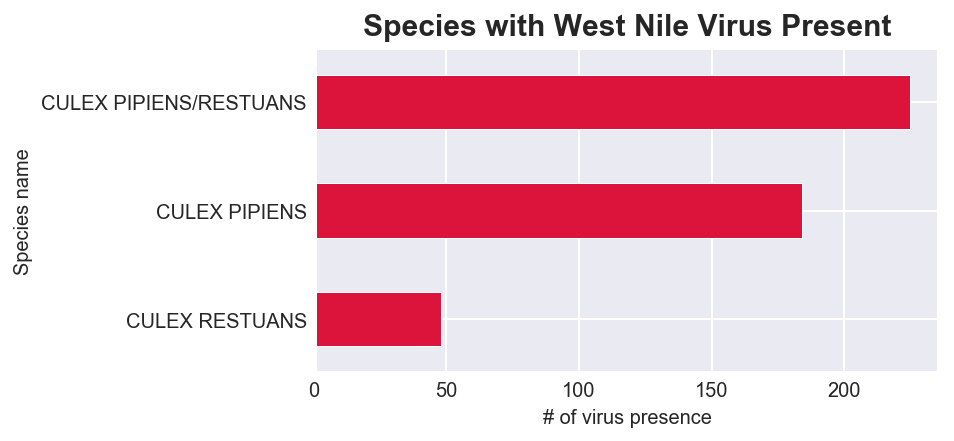

In [33]:
# species with positive WNV 
plt.figure(figsize = (5,3))
sns.set_style("darkgrid")
df.groupby('Species')['WnvPresent'].count().sort_values(ascending = True).plot(kind= 'barh', color = 'crimson')
plt.xticks(fontsize= 10)
plt.yticks(fontsize= 10)
plt.title('Species with West Nile Virus Present', fontsize = 15, weight = 'bold')
plt.xlabel('# of virus presence', fontsize = 10)
plt.ylabel('Species name', fontsize = 10);

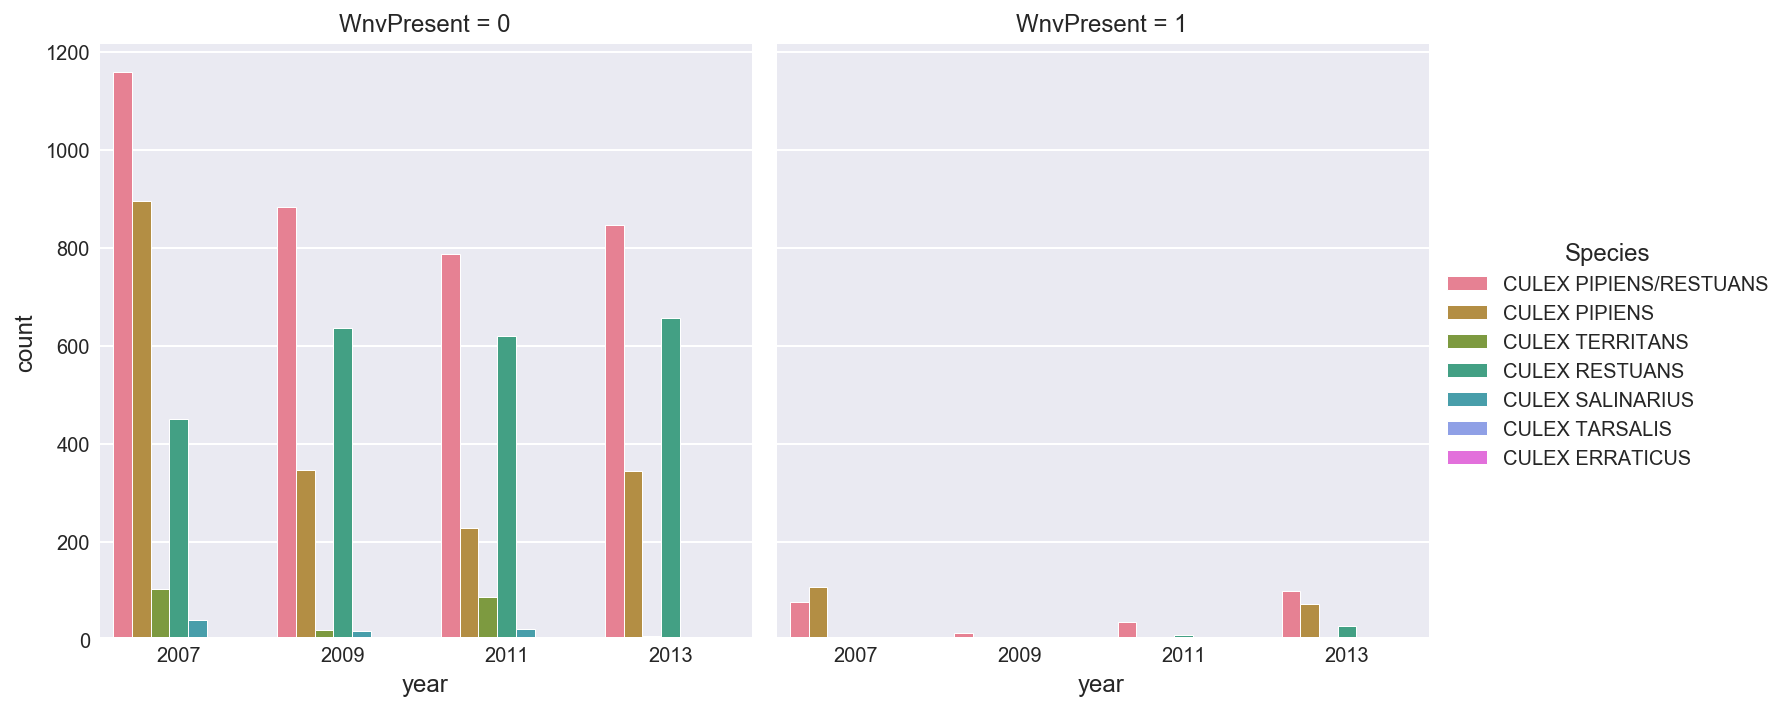

In [34]:
# looking at the distribution of species over the years for both WNV presence and otherwise
sns.catplot(data=train,x='year',hue='Species', col = 'WnvPresent', kind = 'count', palette = 'husl');

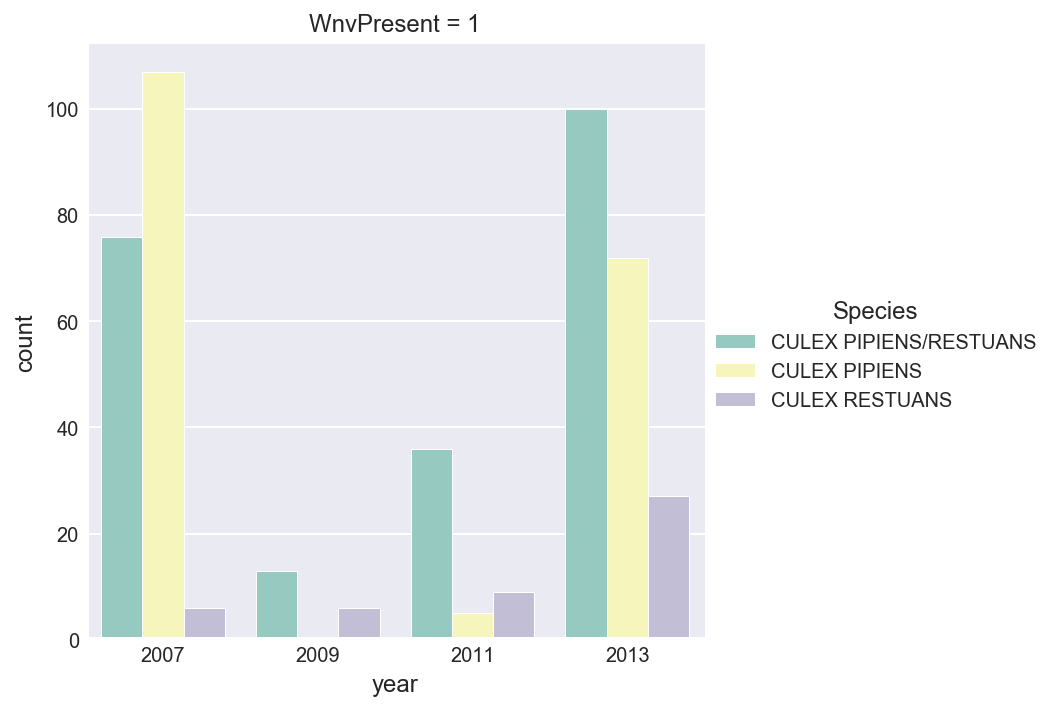

In [35]:
# taking a closer look at the virus presence in species over the years
sns.catplot(data=df,x='year',hue='Species', col = 'WnvPresent', kind = 'count', palette = 'Set3');

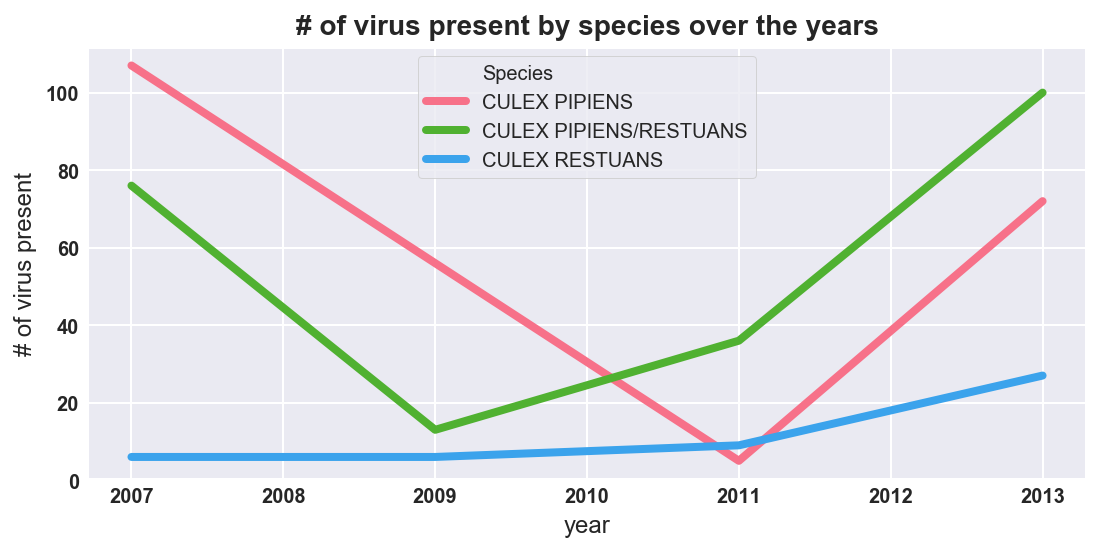

In [36]:
# a better representation of the above? 
df.head()
virus_by_year = df[['year','Species','WnvPresent']].groupby(['year','Species'], as_index = False).agg('sum')
virus_by_year

plt.figure(figsize=(8,4))
sns.lineplot(x = 'year', y = 'WnvPresent', hue = 'Species',data = virus_by_year, palette = 'husl', legend = 'brief')
plt.title("# of virus present by species over the years", fontsize=14, weight = 'bold')
plt.xticks(fontsize= 10, weight = 'bold')
plt.yticks(fontsize= 10, weight = 'bold')
# plt.xlabel('Traps', fontsize = 12)
plt.ylabel('# of virus present', fontsize = 12);

In [37]:
df[['Trap','WnvPresent']].groupby('Trap').agg('sum').sort_values

<bound method DataFrame.sort_values of       WnvPresent
Trap            
T002          15
T003          14
T005           2
T006           4
T008           9
...          ...
T233           6
T235           7
T236           1
T900          29
T903           9

[97 rows x 1 columns]>

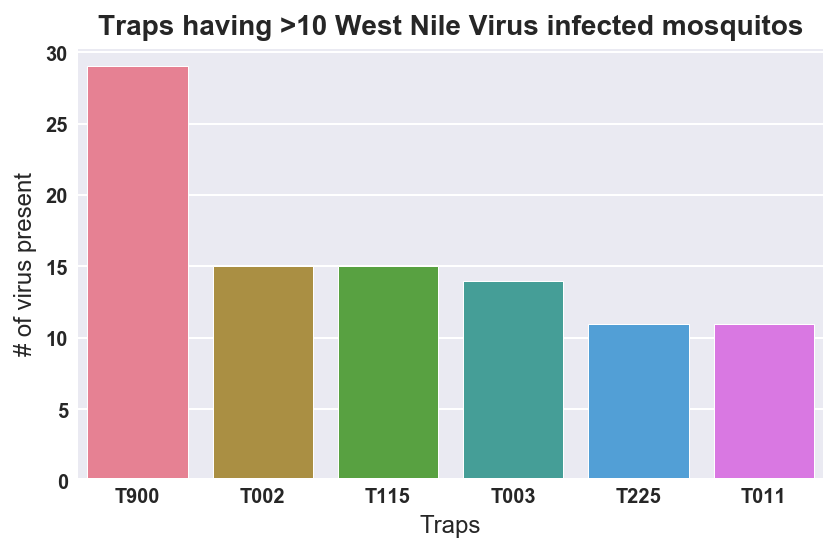

In [38]:
# looking at top traps with virus presence
virus_by_trap = df[['Trap','WnvPresent']].groupby('Trap').agg('sum')
virus_by_trap.sort_values(by='WnvPresent', ascending=False, inplace=True)
virus_by_trap.reset_index(inplace=True)
top_traps =virus_by_trap[virus_by_trap['WnvPresent']>10]

plt.figure(figsize=(6,4))
sns.barplot(data=top_traps, x='Trap', y='WnvPresent', palette = 'husl') #, hue='year')
plt.title("Traps having >10 West Nile Virus infected mosquitos", fontsize=14, weight = 'bold')
plt.xticks(fontsize= 10, weight = 'bold')
plt.yticks(fontsize= 10, weight = 'bold')
plt.xlabel('Traps', fontsize = 12)
plt.ylabel('# of virus present', fontsize = 12);
plt.show()

In [39]:
type(top_traps)
top_traps.info()
df.info()

trap_coords = df[['Trap','Latitude','Longitude']].drop_duplicates()
top_traps=pd.merge(top_traps, trap_coords,  how='left', left_on=['Trap'], right_on = ['Trap'])
top_traps

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Trap        6 non-null      object
 1   WnvPresent  6 non-null      int64 
dtypes: int64(1), object(1)
memory usage: 304.0+ bytes
<class 'pandas.core.frame.DataFrame'>
Int64Index: 457 entries, 36 to 8585
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Trap        457 non-null    object        
 1   Latitude    457 non-null    float64       
 2   Longitude   457 non-null    float64       
 3   Date        457 non-null    datetime64[ns]
 4   Species     457 non-null    object        
 5   WnvPresent  457 non-null    int64         
 6   year        457 non-null    int64         
dtypes: datetime64[ns](1), float64(2), int64(2), object(2)
memory usage: 48.6+ KB


Trap  WnvPresent   Latitude  Longitude
0  T900          29  41.974689 -87.890615
1  T002          15  41.954690 -87.800991
2  T115          15  41.673408 -87.599862
3  T003          14  41.964242 -87.757639
4  T225          11  41.743402 -87.731435
5  T011          11  41.944869 -87.832763

/Users/akhilajoseph/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


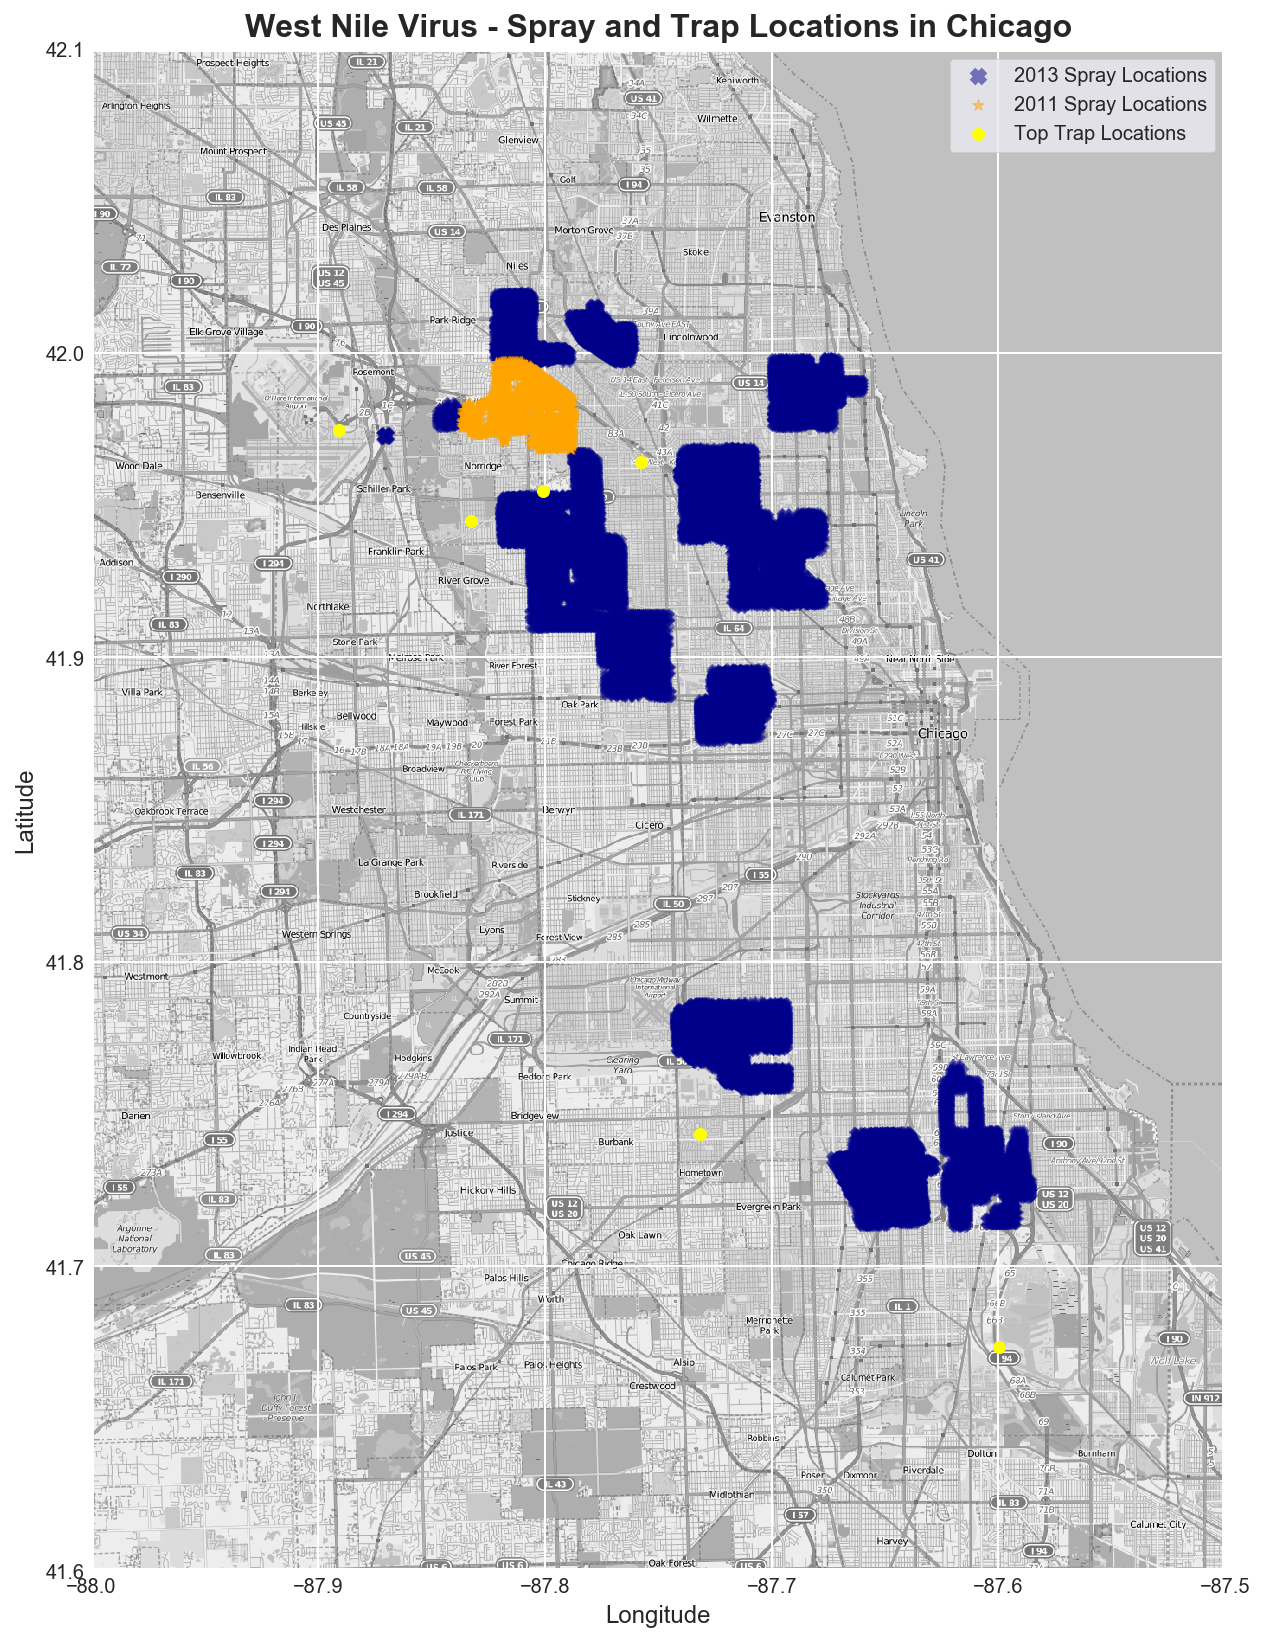

In [40]:
# plotting spray and trap locations by year
mapdata = np.loadtxt("../input/mapdata_copyright_openstreetmap_contributors.txt")

# plot map
aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-88, -87.5, 41.6, 42.1)

plt.figure(figsize=(10,14))
plt.imshow(mapdata, 
           cmap=plt.get_cmap('gray'), 
           extent=lon_lat_box, 
           aspect=aspect)

df.Date = pd.to_datetime(df.Date)
trap_coords = df[['Trap','Latitude','Longitude']].drop_duplicates()

# spray locations
sprays_2013 = spray[spray.Date.dt.year == 2013][['Longitude', 'Latitude']].drop_duplicates()
sprays_2011 = spray[spray.Date.dt.year == 2011][['Longitude', 'Latitude']].drop_duplicates()
sprays_2013 = sprays_2013[sprays_2013['Latitude'] < 42.3]  # excluding outliers
sprays_2011 = sprays_2011[sprays_2011['Latitude'] < 42.3]  # excluding outliers
plt.scatter(sprays_2013['Longitude'], sprays_2013['Latitude'], marker='x', color='darkblue',alpha=.5, label='2013 Spray Locations');
plt.scatter(sprays_2011['Longitude'], sprays_2011['Latitude'], marker='*', color='orange',alpha=.5, label='2011 Spray Locations');

# trap locations
# traps_2013 = df[df.Date.dt.year == 2013][['Trap','Longitude', 'Latitude', 'WnvPresent']]
# traps_2011 = df[df.Date.dt.year == 2011][['Trap','Longitude', 'Latitude', 'WnvPresent']]
locations_toptraps = top_traps[['Longitude', 'Latitude']].drop_duplicates().values

plt.scatter(locations_toptraps[:,0], locations_toptraps[:,1], marker='o', label='Top Trap Locations', color = 'yellow');
# plt.scatter(locations_11[:,0], locations_11[:,1], marker='o', label='2011 Trap Locations', color = 'red');

plt.title('West Nile Virus - Spray and Trap Locations in Chicago', weight = 'bold', size = 16)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(frameon=1);

In [41]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1472 entries, 0 to 2942
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         1472 non-null   datetime64[ns]
 1   Tmax         1472 non-null   int64         
 2   Tmin         1472 non-null   int64         
 3   Tavg         1472 non-null   int64         
 4   Depart       1472 non-null   int64         
 5   DewPoint     1472 non-null   int64         
 6   WetBulb      1472 non-null   float64       
 7   Heat         1472 non-null   int64         
 8   Cool         1472 non-null   int64         
 9   Sunrise      1472 non-null   float64       
 10  Sunset       1472 non-null   float64       
 11  CodeSum      1472 non-null   float64       
 12  PrecipTotal  1472 non-null   float64       
 13  StnPressure  1472 non-null   float64       
 14  SeaLevel     1472 non-null   float64       
 15  ResultSpeed  1472 non-null   float64       
 16  Result

#### Add Weather data to train set

In [42]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8610 entries, 0 to 8609
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Trap        8610 non-null   object        
 1   Latitude    8610 non-null   float64       
 2   Longitude   8610 non-null   float64       
 3   Date        8610 non-null   datetime64[ns]
 4   Species     8610 non-null   object        
 5   WnvPresent  8610 non-null   int64         
 6   year        8610 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(2), object(2)
memory usage: 858.1+ KB


In [43]:
# merging weather dataset to train dataset for modeling later. 
# decided not to include spray dataset with the limited amount of info
train_mod = train.merge(weather, on = 'Date')

In [44]:
train_mod.shape

(8610, 24)

In [45]:
train_mod.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8610 entries, 0 to 8609
Data columns (total 24 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Trap         8610 non-null   object        
 1   Latitude     8610 non-null   float64       
 2   Longitude    8610 non-null   float64       
 3   Date         8610 non-null   datetime64[ns]
 4   Species      8610 non-null   object        
 5   WnvPresent   8610 non-null   int64         
 6   year         8610 non-null   int64         
 7   Tmax         8610 non-null   int64         
 8   Tmin         8610 non-null   int64         
 9   Tavg         8610 non-null   int64         
 10  Depart       8610 non-null   int64         
 11  DewPoint     8610 non-null   int64         
 12  WetBulb      8610 non-null   float64       
 13  Heat         8610 non-null   int64         
 14  Cool         8610 non-null   int64         
 15  Sunrise      8610 non-null   float64       
 16  Sunset

In [46]:
# saving updated train.csv with added weather data to save time from running the above codes
train_mod.to_csv('../data/train_updated.csv', index = False)

In [47]:
# reading the updated train set with weather data
train_mod = pd.read_csv('../data/train_updated.csv')
train_mod.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8610 entries, 0 to 8609
Data columns (total 24 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Trap         8610 non-null   object 
 1   Latitude     8610 non-null   float64
 2   Longitude    8610 non-null   float64
 3   Date         8610 non-null   object 
 4   Species      8610 non-null   object 
 5   WnvPresent   8610 non-null   int64  
 6   year         8610 non-null   int64  
 7   Tmax         8610 non-null   int64  
 8   Tmin         8610 non-null   int64  
 9   Tavg         8610 non-null   int64  
 10  Depart       8610 non-null   int64  
 11  DewPoint     8610 non-null   int64  
 12  WetBulb      8610 non-null   float64
 13  Heat         8610 non-null   int64  
 14  Cool         8610 non-null   int64  
 15  Sunrise      8610 non-null   float64
 16  Sunset       8610 non-null   float64
 17  CodeSum      8610 non-null   float64
 18  PrecipTotal  8610 non-null   float64
 19  StnPre

In [48]:
# after reading from .csv converting date column back again from object type to datetime type
train_mod.Date = pd.to_datetime(train_mod.Date)

### Feature Engineering & Feature Selection

**1. Dummy variables for species created in both train and test set**<br>
**2. Parsed dates into year (performed on top for EDA), month, week of year, month of year**<br>
**3. Coded hot and wet conditions based on dew point and average temperature**<br>
**4. Merged weather dataset to train set for modeling on Date**<br>
**5. Spray set is omitted for now due to the lack of information over the years.**

In [49]:
# Create dummies for Species in train & test set
train_mod = pd.get_dummies(train_mod, columns = ['Species'], drop_first = True)
test = pd.get_dummies(test, columns = ['Species'], drop_first = True)

In [50]:
# make datetime columns for both train and test set
train_mod['Month'] = train_mod['Date'].apply(lambda x:x.month)
train_mod['WeekofYear'] = train_mod['Date'].apply(lambda x:x.weekofyear)
train_mod['YearMonth'] = train_mod['Date'].apply(lambda x: '{}-{:02d}'.format(x.year, x.month))

test['Month'] = test['Date'].apply(lambda x:x.month)
test['WeekofYear'] = test['Date'].apply(lambda x:x.weekofyear)
test['YearMonth'] = test['Date'].apply(lambda x: '{}-{:02d}'.format(x.year, x.month))

In [51]:
# Dummy coding for is_hot (1 for hot, 0 for not hot) and is_dry (1 for dry, 0 for wet)
# dewpoint <= 55 is dry, > 55 is wet
# average temperature <= 65 is cold, >65 is hot
hot = []
dry = []

for c in train_mod['Tavg']:
    if c > 65:
        hot.append(1)
    else:
        hot.append(0)
        
for c in train_mod['DewPoint']:
    if c > 55:
        dry.append(1)
    else:
        dry.append(0)
        
train_mod['is_hot'] = hot
train_mod['is_dry'] = dry

# the temperature fields have served their purpose and now Tavg, Tmax and Tmin as well as 
# Dewpoint columns will be highly correlated to is_hot and is_dry columns just created. 
# Thus dropping them. 
train_mod = train_mod.drop(['Tavg','Tmax','Tmin', 'DewPoint'], axis=1)

In [52]:
train_mod.shape

(8610, 30)

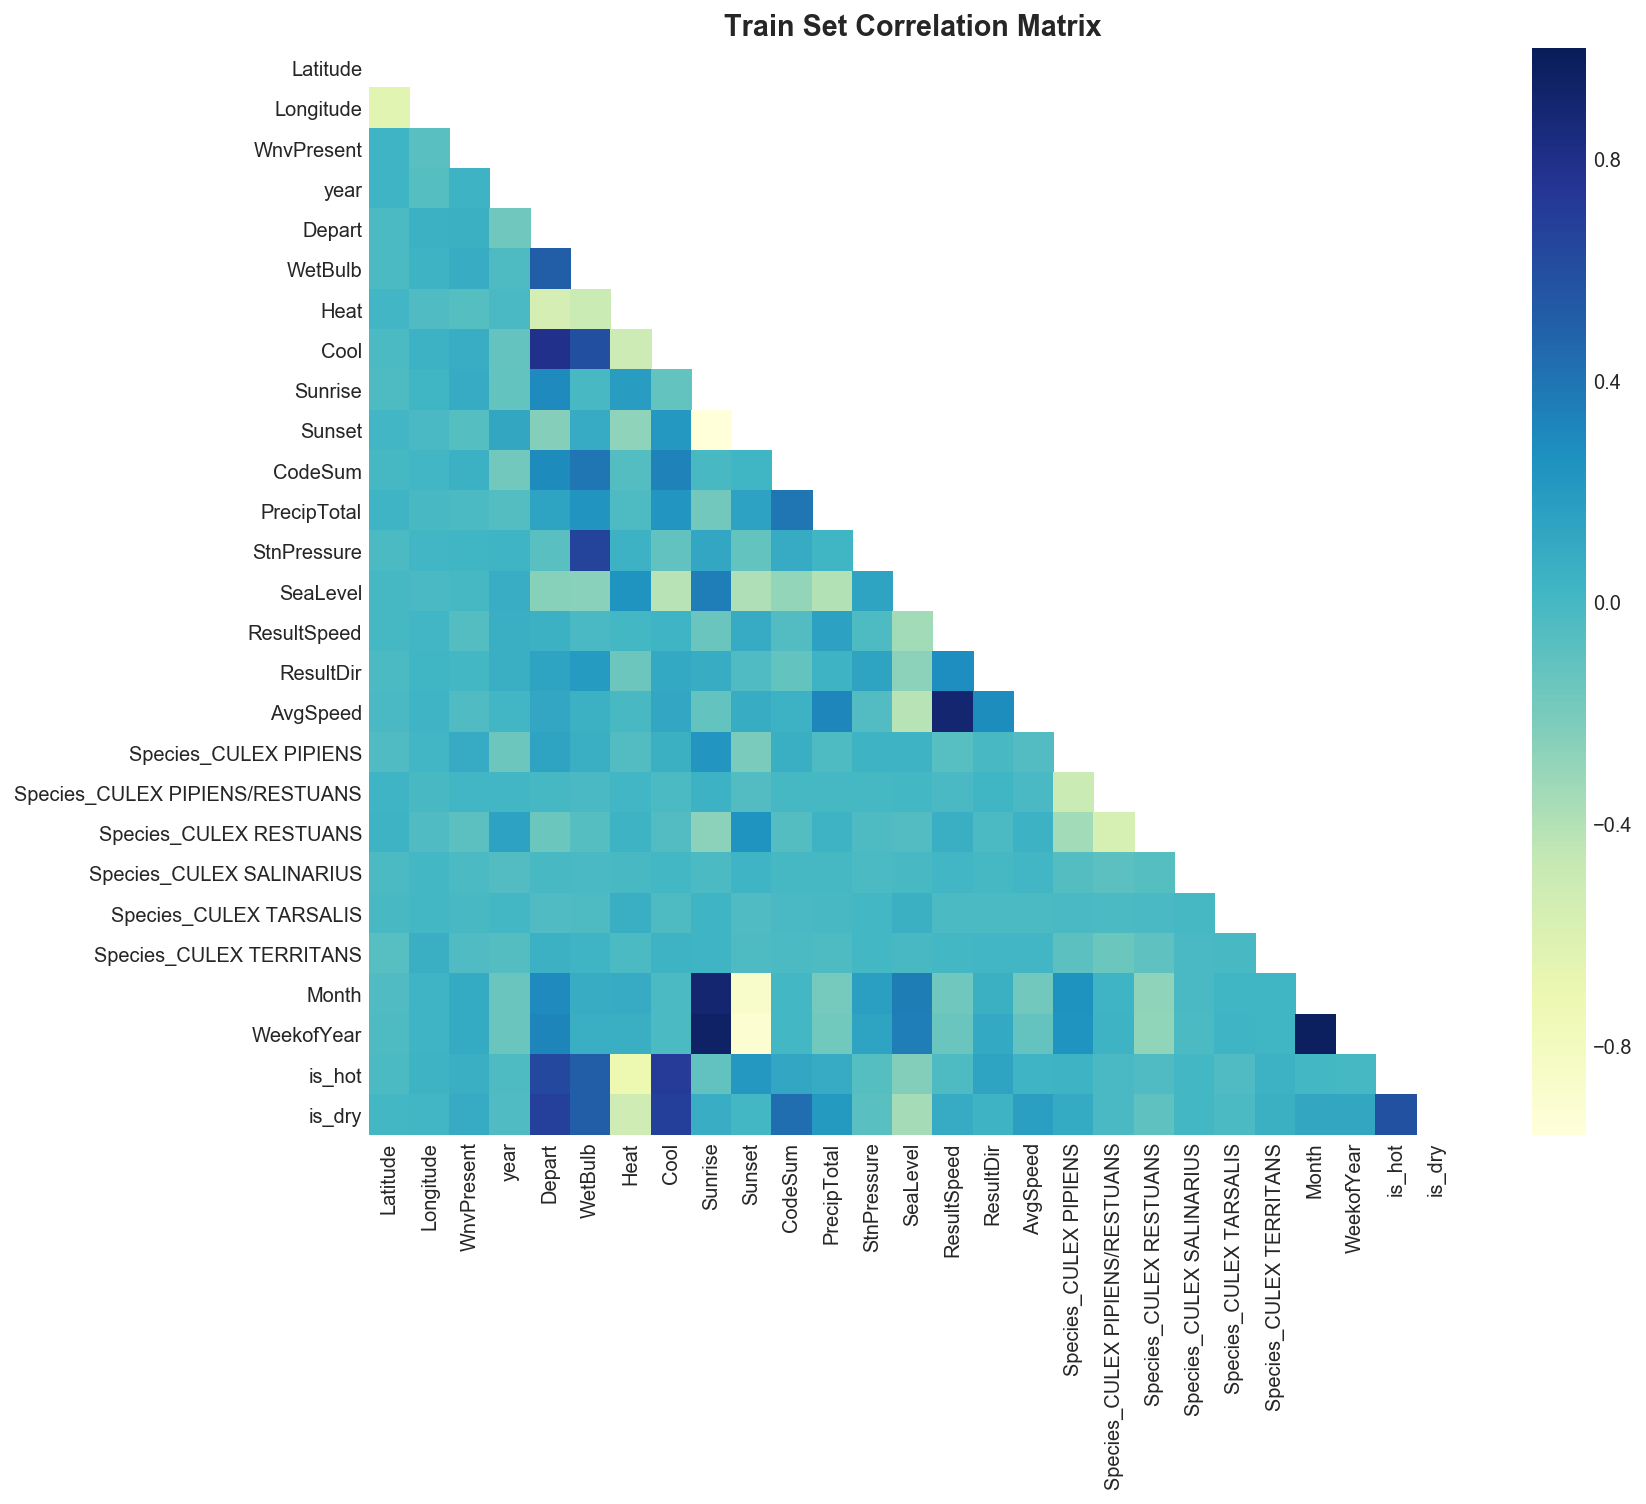

In [53]:
# let's see how correlation looks like for train set
def find_correlation(data,title):
    correlation = data.corr()
    mask = np.zeros_like(correlation)
    mask[np.triu_indices_from(mask)] = True
    with sns.axes_style("white"):
        f, ax = plt.subplots(figsize=(12, 10))
        ax = sns.heatmap(correlation, mask=mask, vmax=1, square=True, cmap= "YlGnBu") 
    plt.title(title, weight = 'bold')

find_correlation(train_mod, 'Train Set Correlation Matrix')

In [54]:
train_mod.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8610 entries, 0 to 8609
Data columns (total 30 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   Trap                            8610 non-null   object        
 1   Latitude                        8610 non-null   float64       
 2   Longitude                       8610 non-null   float64       
 3   Date                            8610 non-null   datetime64[ns]
 4   WnvPresent                      8610 non-null   int64         
 5   year                            8610 non-null   int64         
 6   Depart                          8610 non-null   int64         
 7   WetBulb                         8610 non-null   float64       
 8   Heat                            8610 non-null   int64         
 9   Cool                            8610 non-null   int64         
 10  Sunrise                         8610 non-null   float64       
 11  Suns

In [55]:
abs(train_mod.corr()["WnvPresent"])

Latitude                          0.030907
Longitude                         0.074075
WnvPresent                        1.000000
year                              0.042496
Depart                            0.063704
WetBulb                           0.084084
Heat                              0.058976
Cool                              0.075605
Sunrise                           0.096179
Sunset                            0.058570
CodeSum                           0.055653
PrecipTotal                       0.025935
StnPressure                       0.024171
SeaLevel                          0.002164
ResultSpeed                       0.055551
ResultDir                         0.009709
AvgSpeed                          0.035324
Species_CULEX PIPIENS             0.095826
Species_CULEX PIPIENS/RESTUANS    0.018785
Species_CULEX RESTUANS            0.092170
Species_CULEX SALINARIUS          0.023358
Species_CULEX TARSALIS            0.006252
Species_CULEX TERRITANS           0.037979
Month      

In [56]:
# Identify columns of the highest correlation to 'WNVPresent'
cols = abs(train_mod.corr()["WnvPresent"]).sort_values(ascending=False).round(3).index[1:32]
cols

Index(['WeekofYear', 'Month', 'Sunrise', 'Species_CULEX PIPIENS',
       'Species_CULEX RESTUANS', 'is_dry', 'WetBulb', 'Cool', 'Longitude',
       'is_hot', 'Depart', 'Heat', 'Sunset', 'CodeSum', 'ResultSpeed', 'year',
       'Species_CULEX TERRITANS', 'AvgSpeed', 'Latitude', 'PrecipTotal',
       'StnPressure', 'Species_CULEX SALINARIUS',
       'Species_CULEX PIPIENS/RESTUANS', 'ResultDir', 'Species_CULEX TARSALIS',
       'SeaLevel'],
      dtype='object')

### Modeling

In [57]:
# train test split
X = train_mod[cols]
y = train_mod['WnvPresent']
x_train, x_test, y_train, y_test = train_test_split(X, y,
                                                  test_size = .2,
                                                  random_state=42, stratify=y)

### Baseline Score

For clearer comparison, score of basic Logistic Regression model will be considered as Baseline Score

### 1/5 LogisticRegression

In [58]:
logreg = LogisticRegression()

print("Cross validation on over sampled train data:\n",cross_val_score(logreg, x_train,y_train,n_jobs=-1, cv = 10).mean().round(3),"\n")

print("Cross validation on test data: \n", cross_val_score(logreg, x_test,y_test,n_jobs=-1, cv = 10).mean().round(3), "\n")

Cross validation on over sampled train data:
 0.947 

Cross validation on test data: 
 0.947 



In [59]:
logreg.fit(x_train, y_train)
predicted = logreg.predict_proba(x_train)
print("ROC score on train dataset: ", roc_auc_score(y_train, predicted[:,1]).round(3))
predict = logreg.predict_proba(x_test)
print("ROC score on test dataset: ", roc_auc_score(y_test, predict[:,1]).round(3))

ROC score on train dataset:  0.744
ROC score on test dataset:  0.777


/Users/akhilajoseph/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


### 2/5 Gradient Boost Classifier

In [60]:
gbc = GradientBoostingClassifier()
print("Cross validation on train dataset: \n", cross_val_score(gbc, x_train,y_train, n_jobs=-1, cv = 10).mean().round(3), "\n")
print("Cross validation on test dataset: \n", cross_val_score(gbc, x_test,y_test, n_jobs=-1, cv = 10).mean().round(3), "\n")

Cross validation on train dataset: 
 0.945 

Cross validation on test dataset: 
 0.94 



In [61]:
gbc.fit(x_train, y_train)
predicted = gbc.predict_proba(x_train)
print("ROC score on train dataset: ", roc_auc_score(y_train, predicted[:,1]).round(3))
predict = gbc.predict_proba(x_test)
print("ROC score on test dataset: ", roc_auc_score(y_test, predict[:,1]).round(3))

ROC score on train dataset:  0.902
ROC score on test dataset:  0.872


In [62]:
gboost = GradientBoostingClassifier()
gboost_params = {
    'max_depth': [2,3,4],
    'n_estimators': [100, 125, 150],
    'learning_rate': [.08, .1, .12,1]
}
gb_gs = GridSearchCV(gboost, param_grid=gboost_params, cv=3, verbose = 1)
gb_gs.fit(x_train, y_train)
print(gb_gs.best_score_)
gb_gs.best_params_

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:  2.0min finished


0.946718931475029


{'learning_rate': 0.08, 'max_depth': 2, 'n_estimators': 100}

In [65]:
# Test gbc using gridserachcv updated results
gbc_best = GradientBoostingClassifier(learning_rate=0.08, n_estimators=100, random_state=42, max_depth=2)
gbc_best.fit(x_train, y_train)
predicted = gbc_best.predict_proba(x_train)
print("ROC score on train dataset: ", roc_auc_score(y_train, predicted[:,1]).round(3))
predict = gbc_best.predict_proba(x_test)
print("ROC score on test dataset: ", roc_auc_score(y_test, predict[:,1]).round(3))

ROC score on train dataset:  0.867
ROC score on test dataset:  0.871


### 3/5 Random Forest Classifier

In [66]:
rfc = RandomForestClassifier()
print("Cross validation score on train dataset: ", cross_val_score(rfc, x_train,y_train, n_jobs=-1).mean().round(3), "\n")
print("Cross validation score on test dataset: ", cross_val_score(rfc, x_test,y_test, n_jobs=-1).mean().round(3), "\n")

Cross validation score on train dataset:  0.932 

Cross validation score on test dataset:  0.932 



In [67]:
rfc.fit(x_train, y_train)
predicted = rfc.predict_proba(x_train)
print("ROC score on train dataset: ", roc_auc_score(y_train, predicted[:,1]).round(3))
predict = rfc.predict_proba(x_test)
print("ROC score on test dataset: ", roc_auc_score(y_test, predict[:,1]).round(3))

ROC score on train dataset:  0.999
ROC score on test dataset:  0.784


### 4/5 XGBoost 

In [68]:
xgb = XGBClassifier(n_estimators = 500)
xgb.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=None, n_estimators=500,
              n_jobs=1, nthread=None, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=True, subsample=1)

In [69]:
predicted = xgb.predict_proba(x_train)
print("ROC score on train dataset: ", roc_auc_score(y_train, predicted[:,1]).round(3))
predict = xgb.predict_proba(x_test)
print("ROC score on test dataset: ", roc_auc_score(y_test, predict[:,1]).round(3))

ROC score on train dataset:  0.959
ROC score on test dataset:  0.866


### 5/5 Decision Trees

In [86]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree, ensemble, metrics

dtree = tree.DecisionTreeClassifier()
dtree_model = dtree.fit(x_train, y_train)
predicted = dtree_model.predict_proba(x_train)
print("ROC score on train dataset: ", roc_auc_score(y_train, predicted[:,1]).round(3))
predict = dtree_model.predict_proba(x_test)
print("ROC score on test dataset: ", roc_auc_score(y_test, predict[:,1]).round(3))

ROC score on train dataset:  0.999
ROC score on test dataset:  0.575


In [71]:
# plot feature importances
def plot_feat_imp(model_dict, model_classifier, model_number):
    model_name = '_'.join([model_classifier, str(model_number)])
    feat_imp = pd.DataFrame(model_dict[model_name]['model'].best_estimator_.steps[0][1].feature_importances_,
                            index = X_train[model_number].columns).sort_values(0 ,ascending=False).head(20)
    plt.figure(figsize = (10, 7))
    sns.barplot(x = feat_imp[0], y = feat_imp.index, color = 'skyblue')
    plt.title('Feature importance scores', fontsize=14)
    plt.xlabel('')
    plt.yticks(fontsize = 12)
    plt.tight_layout()

In [112]:
sorted_idx

array([24,  9,  5, 11, 21, 16,  1, 13, 19,  0, 10, 20, 17,  7,  4, 25,  6,
       12,  2, 23, 15, 22,  3, 14, 18,  8])

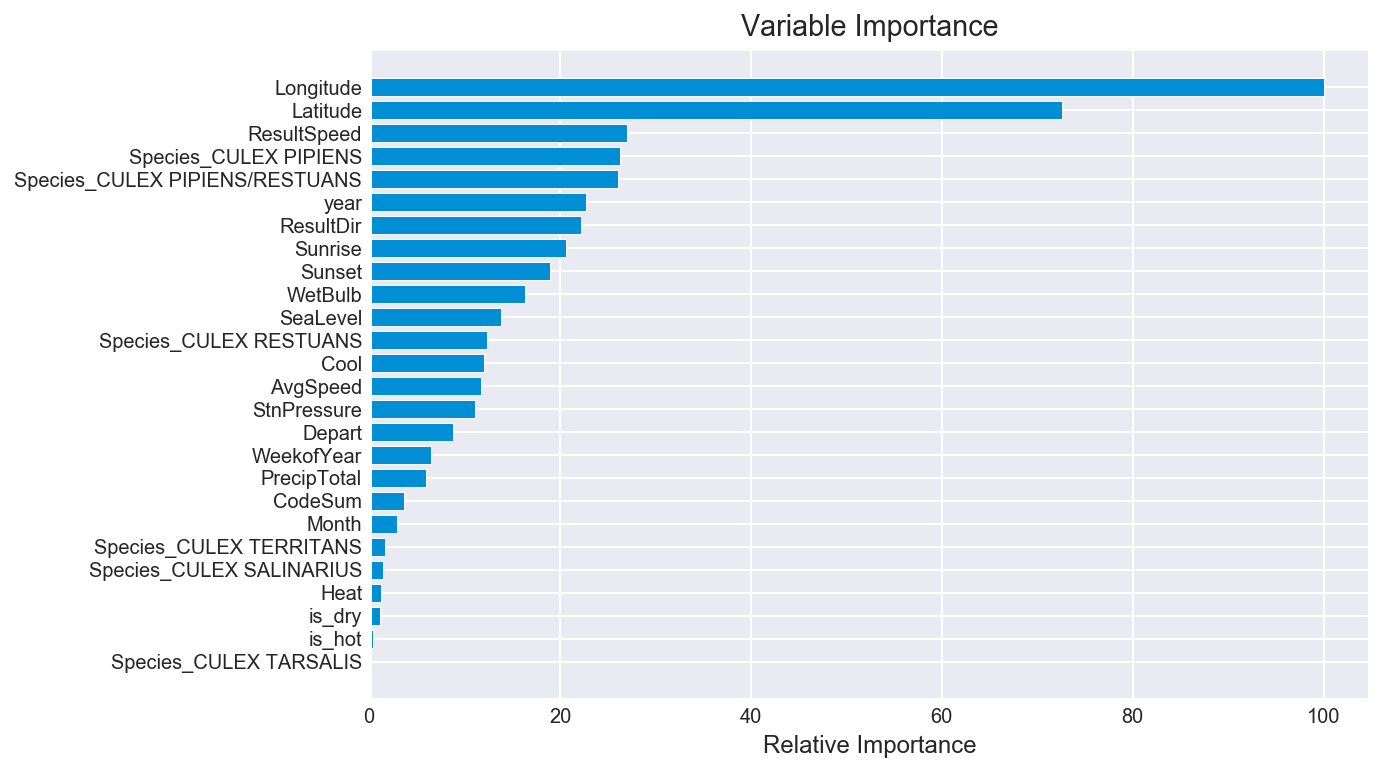

In [117]:
# Plot feature importance
feature_importance = gbc.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .2
plt.figure(figsize = [8,6])
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

### For Kaggle Submission

In [73]:
test.shape
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116293 entries, 0 to 116292
Data columns (total 15 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   Trap                            116293 non-null  object        
 1   Latitude                        116293 non-null  float64       
 2   Longitude                       116293 non-null  float64       
 3   Date                            116293 non-null  datetime64[ns]
 4   year                            116293 non-null  int64         
 5   Species_CULEX PIPIENS           116293 non-null  uint8         
 6   Species_CULEX PIPIENS/RESTUANS  116293 non-null  uint8         
 7   Species_CULEX RESTUANS          116293 non-null  uint8         
 8   Species_CULEX SALINARIUS        116293 non-null  uint8         
 9   Species_CULEX TARSALIS          116293 non-null  uint8         
 10  Species_CULEX TERRITANS         116293 non-null  uint8  

In [80]:
test_mod = test.merge(weather, on = 'Date')
test_mod.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116293 entries, 0 to 116292
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   Trap                            116293 non-null  object        
 1   Latitude                        116293 non-null  float64       
 2   Longitude                       116293 non-null  float64       
 3   Date                            116293 non-null  datetime64[ns]
 4   year                            116293 non-null  int64         
 5   Species_CULEX PIPIENS           116293 non-null  uint8         
 6   Species_CULEX PIPIENS/RESTUANS  116293 non-null  uint8         
 7   Species_CULEX RESTUANS          116293 non-null  uint8         
 8   Species_CULEX SALINARIUS        116293 non-null  uint8         
 9   Species_CULEX TARSALIS          116293 non-null  uint8         
 10  Species_CULEX TERRITANS         116293 non-null  uint8  

In [81]:
# adding feature engineered variables to test set as well
hot = []
dry = []

for c in test_mod['Tavg']:
    if c > 65:
        hot.append(1)
    else:
        hot.append(0)
        
for c in test_mod['DewPoint']:
    if c > 55:
        dry.append(1)
    else:
        dry.append(0)
        
test_mod['is_hot'] = hot
test_mod['is_dry'] = dry


# the temperature fields have served their purpose and now Tavg, Tmax and Tmin as well as 
# Dewpoint columns will be highly correlated to is_hot and is_dry columns just created. 
# Thus dropping them. 
test_mod = test_mod.drop(['Tavg','Tmax','Tmin', 'DewPoint'], axis=1)

In [82]:
test_mod.columns
cols

Index(['WeekofYear', 'Month', 'Sunrise', 'Species_CULEX PIPIENS',
       'Species_CULEX RESTUANS', 'is_dry', 'WetBulb', 'Cool', 'Longitude',
       'is_hot', 'Depart', 'Heat', 'Sunset', 'CodeSum', 'ResultSpeed', 'year',
       'Species_CULEX TERRITANS', 'AvgSpeed', 'Latitude', 'PrecipTotal',
       'StnPressure', 'Species_CULEX SALINARIUS',
       'Species_CULEX PIPIENS/RESTUANS', 'ResultDir', 'Species_CULEX TARSALIS',
       'SeaLevel'],
      dtype='object')

In [83]:
test_mod = test_mod[cols]

In [84]:
# checking columns of both test_mod to ensure its same as x_train  
test_mod.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116293 entries, 0 to 116292
Data columns (total 26 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   WeekofYear                      116293 non-null  int64  
 1   Month                           116293 non-null  int64  
 2   Sunrise                         116293 non-null  float64
 3   Species_CULEX PIPIENS           116293 non-null  uint8  
 4   Species_CULEX RESTUANS          116293 non-null  uint8  
 5   is_dry                          116293 non-null  int64  
 6   WetBulb                         116293 non-null  float64
 7   Cool                            116293 non-null  int64  
 8   Longitude                       116293 non-null  float64
 9   is_hot                          116293 non-null  int64  
 10  Depart                          116293 non-null  int64  
 11  Heat                            116293 non-null  int64  
 12  Sunset          

In [85]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6888 entries, 1373 to 3744
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   WeekofYear                      6888 non-null   int64  
 1   Month                           6888 non-null   int64  
 2   Sunrise                         6888 non-null   float64
 3   Species_CULEX PIPIENS           6888 non-null   uint8  
 4   Species_CULEX RESTUANS          6888 non-null   uint8  
 5   is_dry                          6888 non-null   int64  
 6   WetBulb                         6888 non-null   float64
 7   Cool                            6888 non-null   int64  
 8   Longitude                       6888 non-null   float64
 9   is_hot                          6888 non-null   int64  
 10  Depart                          6888 non-null   int64  
 11  Heat                            6888 non-null   int64  
 12  Sunset                         

In [93]:
sub = pd.DataFrame(logreg.predict_proba(test_mod)[:,1], columns = ['WnvPresent'])
sub.set_index(np.arange(1, test_mod.shape[0] + 1), inplace=True)
sub = sub.reset_index().rename(columns = {'index':'Id'})
sub.WnvPresent = sub.WnvPresent.round(0).astype(int)
sub.to_csv('../data/submission_logreg.csv', index = False)

# kaggle score : 0.50

In [94]:
sub = pd.DataFrame(gbc.predict_proba(test_mod)[:,1], columns = ['WnvPresent'])
sub.set_index(np.arange(1, test_mod.shape[0] + 1), inplace=True)
sub = sub.reset_index().rename(columns = {'index':'Id'})
sub.WnvPresent = sub.WnvPresent.round(0).astype(int)
sub.to_csv('../data/submission_gbc.csv', index = False)

# kaggle score: 0.56

In [95]:
sub = pd.DataFrame(rfc.predict_proba(test_mod)[:,1], columns = ['WnvPresent'])
sub.set_index(np.arange(1, test_mod.shape[0] + 1), inplace=True)
sub = sub.reset_index().rename(columns = {'index':'Id'})
sub.WnvPresent = sub.WnvPresent.round(0).astype(int)
sub.to_csv('../data/submission_rfc.csv', index = False)

# kaggle score: 0.52

In [96]:
sub = pd.DataFrame(xgb.predict_proba(test_mod)[:,1], columns = ['WnvPresent'])
sub.set_index(np.arange(1, test_mod.shape[0] + 1), inplace=True)
sub = sub.reset_index().rename(columns = {'index':'Id'})
sub.WnvPresent = sub.WnvPresent.round(0).astype(int)
sub.to_csv('../data/submission_xgb.csv', index = False)

# kaggle score: 0.53

In [97]:
sub = pd.DataFrame(dtree_model.predict_proba(test_mod)[:,1], columns = ['WnvPresent'])
sub.set_index(np.arange(1, test_mod.shape[0] + 1), inplace=True)
sub = sub.reset_index().rename(columns = {'index':'Id'})
sub.WnvPresent = sub.WnvPresent.round(0).astype(int)
sub.to_csv('../data/submission_dtree_model.csv', index = False)

# kaggle score: 0.52

In [87]:
sub = pd.DataFrame(gbc_best.predict_proba(test_mod)[:,1], columns = ['WnvPresent'])
sub.set_index(np.arange(1, test_mod.shape[0] + 1), inplace=True)
sub = sub.reset_index().rename(columns = {'index':'Id'})
sub.WnvPresent = sub.WnvPresent.round(0).astype(int)
sub.to_csv('../data/submission_gbcbest.csv', index = False)

# kaggle score: 0.49

#### Kaggle submission

<img src = "Kaggle.PNG"/>

### Cost-Benefit Analysis

From an economical/budget point of view, 

<b>If CDC decides to proceed with the spraying, the estimated total costs incurred is approximately USD144,035 per person:</b>
- Vector Control Cost: According to this [source](https://www.cmmcp.org/pesticide-information/pages/zenivex-e4-etofenprox), the material being used to control the adult mosquitoes is Zenivex™, as this type of insecticide presents a minimal risk to humans. This is applied at a rate of [1.5 fluid ounces per acre](https://abc7chicago.com/archive/9206273/), which works out to be approximately USD0.75 per acre (the cost of Zenivex E4 is about USD80 per gallon (~160 fluid ounce), according to [North Dakota Department of Health](http://www.gfmosquito.com/wp-content/uploads/2013/06/2013-North-Dakota-Bid-Tabulation.pdf). Following, taking Illionois state as an example, which has a total area of [57,915 sq mi/149,997 km2](https://en.wikipedia.org/wiki/Illinois) (approx. 37,065,065 acre). Hence, estimated cost of spraying is USD27,798,798 (Total acre x USD0.75 per acre of spray). According to [CDC website] (https://www.cdc.gov/westnile/resources/pdfs/data/WNV-Disease-Cases-PVDs-by-State-2018-P.pdf), total cases of infected (including deaths) amount to 176 cases (i.e. Cost of infected/death per person is USD144,035). 

<b>If CDC decides NOT to proceed with the spraying, the estimated total costs incurred is approximately USD108,363 per person:</b>
- Medical cost per person est. [USD46,530](https://wwwnc.cdc.gov/eid/article/16/3/09-0667_article): 
 - Approx. USD33,143 per inpatient for all treatments
 - Approx. USD6,317 per outpatient for all treatments 
 - Approx. USD18,097 per WNND (West Nile neuroinvasive disease) patient estimated to have spent time in a nursing home 
- Productivity/Income loss based on personal income in Illinois per person est. [USD58,935](https://www.statista.com/statistics/205235/per-capita-personal-income-in-illinois/):
 - The amount of losses a city will face from an incapacitated workforce may be larger as more people dying/falling ill leds to decreased workplace productivity (and decrease total income as less people are able to work)
- There may be potential savings from public pensions and medical/healthcare costs spent on the elderly as there are more deaths (espeically since the risk of severe illness and death is highest for people over 50 years old, although people of all ages can become ill).

From a budget point of view, it appears that the overall cost of spraying outweighs the benefits. However, this does not take into account the cost of a single human’s lives, which is nearly impossible/inhuman to place a dollar value on someone’s life. 

Therefore, it is important to take into account the human benefits from mosquito spraying, which include increased quality of life from fewer people falling sick and dying, increased workplace productivity from fewer people falling ill and going on medical leave, as well as savings in hospital expenses from treating WNV patients. The cost of death in loved ones would potentially lead to wider mental health issues within the family and potentially affecting the overall quality of workforce. Additionally, there are losses within the tourism and entertainment sectors which is challenging to quantify and calculate.

In conclusion, CDC's mission aims to protect America from health, safety and security threats. CDC aims to increase the health security of our nation. As the nation’s health protection agency, CDC saves lives and protects people from health threats. To accomplish CDC's mission, CDC should consider spraying the outskirts of the city first as the human benefit of spraying outweighs the costs. 

### Conclusions and Recommendations

**Conclusion**<br>
1. Griadient Boost Classifier scored the best score in Kaggle as well as on test set. The classifer also has the least variance between test and training scores proving that it is not overfit.<br>
<br>
2. Based on feature importance it is evident that the virus is prevalent in certain locations (latitude and logitude has high importance), where certain species of the mosquitoes grow. <br>
<br>
3. Certain time of the year with longer day light hours (sunrise and sunset timings) are also seen to be influencing the presence of WN Virus. <br>
<br>
4. These features can be used to determine the locations/ traps and decide when and where to concentrate on spraying efforts. 

**Model Limitations**<br>
<br>
Model did not perform well on the out of sample set from Kaggle and there is a significant variance in AUC score between the 2 scores. This may be due to the way the in sample training and test sets are split vs. the train and test set split that Kaggle did. 

**Recommendations to improve on the model**<br>
1. Enhance the model with additional feature engineering and time series application. Elaborate feature engineering to be perfomed on weather dataset followed by feature selection to drop correlated features.<br>
<br>
2. Current model doesn't train on trap information. Trap information based on latitude and longitude is key to advice on spraying locations. Top traps could be dummified for model training purpose.<br> 
<br>
3. NumMosquito feature from train set that had high correlation to virus presence was dropped to align training set with out of sample set. There is opportunity to predict NumMosquito feature first using regression and then predict presence of WNV since the 2 are highly correlated. <br>
<br>
4. Spray dataset was completely dropped from modeling due to lack of information for years other than 2013. Would be worthwhile to include spray information provided adequate data is available. 